In [1]:
import scipy.io as sio
from sklearn import preprocessing
import parmap
import numpy as np
from __future__ import division

lb = preprocessing.LabelBinarizer()
lb.fit([1,2,3,4,5,6,7,8,9,10])
train = sio.loadmat("train.mat")
test = sio.loadmat("test.mat")
label = train['y']
img = train['X']
img = np.rollaxis(img,3,0)

label = np.ravel(label)
# Process the label so that it can be read by tensorflow
label = lb.transform(label)

Xtest = test['X']
Xtest = np.rollaxis(Xtest, 3,0)
ytest = test['y']
ytest = np.ravel(ytest)
ytest = lb.transform(ytest)

print img.shape, label.shape

(73257, 32, 32, 3) (73257, 10)


In [2]:

def process_(i, img):
    currentImg = img[i,:,:,:]

    # Grayscale image
    grayscale = np.dot(currentImg[:,:,:3], [0.299, 0.587, 0.114])

    return np.ravel(grayscale)

num_img = img.shape[0]
num_img_test = Xtest.shape[0]
processed = parmap.map(process_, range(0,num_img), img)
processed = np.array(processed)
test_processed = parmap.map(process_, range(0,num_img_test), Xtest)
test_processed = np.array(test_processed)

In [3]:
# batch = tf.train.shuffle_batch([img, label], batch_size=100, capacity=50000, 
#                                num_threads=4, min_after_dequeue=10000)
# batch[0].shape
# batch[1].shape
print test_processed.shape
print ytest.shape

(26032, 1024)
(26032, 10)


In [4]:
# Function to get batch of data
class SVHN:
    lb = preprocessing.LabelBinarizer()
    lb.fit([1,2,3,4,5,6,7,8,9,10])
    def __init__(self, data):
#         self.data = sio.loadmat(filename)
        self.img = data[0]
        self.label = data[1]
#         self.label = SVHN.lb.transform(np.ravel(self.label))
        self.indx = np.arange(self.label.shape[0])
#         self.state = np.random.RandomState(42)
#         self.batchsize = batchsize
#         self.num_batch = 
    def get_next_batch(self,batchsize):
        np.random.shuffle(self.indx)
        return self.img[self.indx[:batchsize],:], self.label[self.indx[:batchsize],:]
mysvhn = SVHN([processed, label])


(100, 1024) (100, 10)
[0 0 0 0 0 0 0 0 0 1]


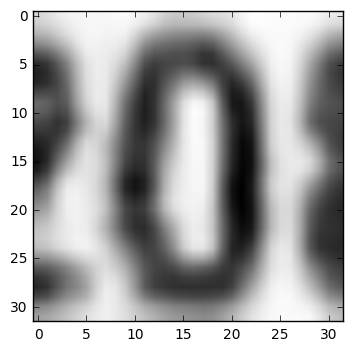

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

batch = mysvhn.get_next_batch(100)
print batch[0].shape, batch[1].shape
plt.imshow(batch[0][3,:].reshape([32,32]),cmap='gray')
print batch[1][3]

In [6]:
# #Test cell
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
# batch = mnist.train.next_batch(100)
# print batch[0].shape
# print batch[1].shape

In [7]:
import tensorflow as tf
from sklearn import metrics
import numpy as np
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


# Initialize weight with randomized number drawn from normal distribition
def init_weight(shape, name):
    return tf.Variable(tf.random_normal(shape, stddev=0.1), name=name)
# Initialize bias with constant
def init_bias(shape, name):
    return tf.Variable(tf.constant(0.1, shape=shape), name=name)

# 2D convolution
def conv2d(x,w):
    """
    X is input tensor, W * H * D * n
    w is weight tensor, W' * H' * D * N
    return out, W * H * N
    padding='same'
    stride=[1,1,1,1]
    """
    return tf.nn.conv2d(x,w, strides=[1,1,1,1], padding='SAME',name="Convolution");

# Max pooling layer
def max_pool_2x2(x):
    """
    2 by 2 max pool
    filter size: 2 by 2
    stride: 2, 2
    padding='same'
    """
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")


## Define network structure

In [8]:
def model(x, w, b, keep_prob):
    """
    X is input tensor: 28 * 28 * 1 * n
    w is list of tensors of weight, len(w)=4 for this architecture
    b is list of bias, len(b)=4 correspondingly
    """
    x = tf.reshape(x,[-1, 32, 32, 1])
    
    # 2 Layers network, each layer contains a convolution, reLU and Max pool operation
    
    # Layer 1
    with tf.name_scope("Layer1"):
        with tf.name_scope("Convolutional_layer1"):
            h_conv1 = (conv2d(x, w[0]) + b[0])
        with tf.name_scope("ReLU_layer1"):
            h_relu1 = tf.nn.relu(h_conv1)
        with tf.name_scope("Max_pooling_layer1"):
            h_pool1 = max_pool_2x2(h_relu1)
        
    # Layer 2
    with tf.name_scope("Layer2"):
        with tf.name_scope("Convolutional_layer2"):
            h_conv2 = conv2d(h_pool1, w[1]) + b[1]
        with tf.name_scope("ReLU_layer2"):
            h_relu2 = tf.nn.relu(h_conv2)
        with tf.name_scope("Max_pooling_layer2"):
            h_pool2 = max_pool_2x2(h_relu2)
    
    # Reshape h_pool2
    h_pool2 = tf.reshape(h_pool2,[-1, 8*8*64])
    
    # Fully connected layer
    with tf.name_scope("Fully_Connected_layer"):
        with tf.name_scope("Activation_layer"):
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2, w[2]) + b[2])
#         keep_prob = tf.placeholder(tf.float32)
        with tf.name_scope("Dropout"):
            h_drop = tf.nn.dropout(h_fc1, keep_prob)
        with tf.name_scope("Read_out_layer"):
            y_conv = tf.matmul(h_drop, w[3]) + b[3]
    return y_conv

## Initialize weights and bias

In [9]:
# Input images
x = tf.placeholder(tf.float32, shape=[None,32*32], name="Input_images")

# Input labels
y_ = tf.placeholder(tf.float32, shape=[None, 10], name="Input_labels")

# Weights and bias for layer 1
w_0 = init_weight([3,3,1,32],"Layer1_weights")
b_0 = init_bias([32], "Layer1_bias")

# Weights and bias for layer 2
w_1 = init_weight([5,5,32,64], "Layer2_weights")
b_1 = init_bias([64], "Layer2_bias")

# Weights and bias for fully connected layer 1
w_2 = init_weight([8*8*64, 1024], "Fully_connected_layer_weight1")
b_2 = init_bias([1024],"Fully_connected_layer_bias1")

# Weights and bias for fully connected layer 2
w_3 = init_weight([1024, 10], "Read_out_weight")
b_3 = init_bias([10], "Read_out_bias")

# Add summary for later visualization and analysis
tf.histogram_summary("w_0_summ", w_0)
tf.histogram_summary("w_1_summ", w_1)
tf.histogram_summary("w_2_summ", w_2)
tf.histogram_summary("w_3_summ", w_3)

tf.histogram_summary("b_0_summ", b_0)
tf.histogram_summary("b_1_summ", b_1)
tf.histogram_summary("b_2_summ", b_2)
tf.histogram_summary("b_3_summ", b_3)

keep_prob = tf.placeholder(tf.float32, name="keeping_probability")

In [10]:
y_h = model(x,[w_0,w_1,w_2,w_3],[b_0,b_1,b_2,b_3], keep_prob)

# Cost function
with tf.name_scope("Cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_h, y_))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)
    # Add summary of cost
    tf.scalar_summary("Cost", cost)

# Accuracy function
with tf.name_scope("Accuracy"):
    correct = tf.equal(tf.argmax(y_h,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    tf.scalar_summary("Accuracy", accuracy)

# with tf.InteractiveSession() as sess:
sess = tf.InteractiveSession()
saver = tf.train.Saver()

writer = tf.train.SummaryWriter("logs/", sess.graph)
merged = tf.merge_all_summaries()
tf.global_variables_initializer().run()



In [ ]:
# Start training
for i in xrange(100000):
    batch = mysvhn.get_next_batch(100)
    sess.run(train_step, feed_dict={x:batch[0], y_:batch[1], keep_prob:0.5})
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_:batch[1], keep_prob:1.0})
        summary, acc = sess.run([merged, accuracy], feed_dict={x:batch[0], y_:batch[1], keep_prob:1.0})
        writer.add_summary(summary, i)
        print "Step {}, training accuracy {}".format(i, train_accuracy)


In [ ]:
# save_path = saver.save(sess, "variables/CNN_1.ckpt")

In [11]:
# Test cell

import numpy as np
import pandas as pd

# test_img = mnist.test.images
# test_label = mnist.test.labels
# print test_img.shape

# res = tf.pack(tf.argmax(y_h,1), tf.argmax(y_,1))
confusion = np.zeros([10,10], int)

temp_accuracy = []
predicted = tf.argmax(y_h,1)
saver.restore(sess, "variables/CNN_1.ckpt")
temp_result = []
for i in xrange(0,test_processed.shape[0],100):
    top = min(ytest.shape[0], i+100)
    temp = accuracy.eval(feed_dict={x: test_processed[i:top,:], y_: ytest[i:top,:], 
                                    keep_prob: 1.0})
    temp_accuracy.append(temp)
    print("temp accuracy %g"%temp)
#     ans = res.eval(feed_dict={x: test_img[i:i+100,:], y_: test_label[i:i+100], 
#                                     keep_prob: 1.0})
#     for p in ans.T:
#         confusion[p[0], p[1]]+=1
    temp_result.append(predicted.eval(feed_dict={x:test_processed[i:i+100,:], y_: ytest[i:i+100,:], 
                                    keep_prob: 1.0}))



temp accuracy 0.85
temp accuracy 0.9
temp accuracy 0.87
temp accuracy 0.89
temp accuracy 0.87
temp accuracy 0.83
temp accuracy 0.85
temp accuracy 0.83
temp accuracy 0.84
temp accuracy 0.9
temp accuracy 0.86
temp accuracy 0.87
temp accuracy 0.88
temp accuracy 0.85
temp accuracy 0.86
temp accuracy 0.84
temp accuracy 0.85
temp accuracy 0.88
temp accuracy 0.89
temp accuracy 0.89
temp accuracy 0.88
temp accuracy 0.86
temp accuracy 0.83
temp accuracy 0.92
temp accuracy 0.9
temp accuracy 0.84
temp accuracy 0.91
temp accuracy 0.84
temp accuracy 0.87
temp accuracy 0.86
temp accuracy 0.81
temp accuracy 0.96
temp accuracy 0.91
temp accuracy 0.89
temp accuracy 0.85
temp accuracy 0.93
temp accuracy 0.89
temp accuracy 0.85
temp accuracy 0.89
temp accuracy 0.83
temp accuracy 0.93
temp accuracy 0.88
temp accuracy 0.9
temp accuracy 0.94
temp accuracy 0.86
temp accuracy 0.88
temp accuracy 0.82
temp accuracy 0.91
temp accuracy 0.86
temp accuracy 0.88
temp accuracy 0.9
temp accuracy 0.84
temp accuracy 0.8

In [12]:

# b = np.hstack(temp_result)

# mnist_ = input_data.read_data_sets('MNIST_data', one_hot=False)
# test_label = mnist_.test.labels
# print test_label

# print "Confusion matrix \n{}".format(metrics.confusion_matrix(test_label, b))

temp_accuracy_ = np.array(temp_accuracy)
print "Overall accuracy {}".format(np.mean(temp_accuracy_))
print temp_accuracy_.shape

Overall accuracy 0.87385058403
(261,)
